# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import numpy as np
import pandas as pd
import seaborn as sb
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json
from collections import OrderedDict
import time
from PIL import Image
from torch.autograd import Variable

In [2]:
# Animates a line graph for accuracy
def plotGraph(xar,yar):
    # set bin edges, compute centers
    ybin_edges = np.arange(0, 100, 5)
    ybin_centers = (ybin_edges + 0.5/2)[:-1]
    xar, yar = np.array(xar), np.array(yar)
    
    #Creating pandas dataframe from numpy array
    df = pd.DataFrame({'X':xar,'Y':yar})
    
    
    # set bin edges, compute centers
    xbin_edges = np.arange(0.5, df['num_var1'].max()+0.25, 0.25)
    xbin_centers = (xbin_edges + 0.25/2)[:-1]

    # compute statistics in each bin
    data_ybins = pd.cut(df['Y'], ybin_edges,  include_lowest = True)
    y_means = df['Y'].groupby(data_ybins).mean()
    

    plt.plot(xar, yar)
    ylabels = np.arange(0, 100, step=5)
    plt.ylabel("ACCURACY")
    plt.xlabel("STEPS")
    #fig = plt.figure()
    #ax1 = fig.add_subplot(1,1,1)
    plt.yticks(range(0,len(yar)),ylabels)
    print("X Array = {} Y Array = {}".format(xar,yar) )
     
   
    #ax1.plot(xar,yar, linewidth=2, yticks =  np.arange(0, 100, step=5))
    plt.show()
    
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    test_loss = 0
    accuracy = 0
    print("PERFORMING VALIDATION CHECK")
    for ii, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
  
        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [4]:
# DONE: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

# DONE: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# DONE: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(test_data, batch_size=32)


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)  

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [8]:
# DONE: Build and train your network
print("BUILDING THE NEURAL NETWORK")
epochs = 5
print_every = len(trainloader)
steps = 0
learn_rate = 0.001
perceptron_sizes = [25088,4096,1000,102]
drop_rate = [0.5,0.2]
model = models.vgg16(pretrained=True)

# prevents backpropogation through the pretrained network, hence we are only training our classifier
for param in model.parameters():
    param.requires_grad = False

# creates a new classifier for your requirement
classifier = nn.Sequential(OrderedDict([
                         ('fc1', nn.Linear(perceptron_sizes[0], perceptron_sizes[1])),
                         ('relu1', nn.ReLU()),
                         ('dropout1', nn.Dropout(p=drop_rate[0])),
                         ('fc2', nn.Linear(perceptron_sizes[1], perceptron_sizes[2])),
                         ('relu2', nn.ReLU()),
                         ('dropout2', nn.Dropout(p=drop_rate[1])),
                         ('fc3', nn.Linear(perceptron_sizes[2], perceptron_sizes[3])),
                         ('output', nn.LogSoftmax(dim=1))
                         ]))


# adds the new classifier to the model
model.classifier = classifier


print("TRAINING THE NEURAL NETWORK")
# checks if GPU is available else runs on CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("-------------- DEVICE --------------")
print(device)

criterion = nn.NLLLoss()

# only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=learn_rate)

stepsArr = []
accuracyArr = []

# load the model to the device GPU / CPU
model.to(device)

print("Trainloader has {} images".format(len(trainloader)))

# run a pre-set amount of times (epochs)
for e in range(epochs):
    running_loss = 0
    accuracy = 0
    
    for ii, (images, labels) in enumerate(trainloader):
        steps += 1
        
        images, labels = images.to(device), labels.to(device)
            
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        ps = torch.exp(outputs)
  
        _, predicted = torch.max(outputs.data, 1)
        running_loss += loss.item()
        
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = equality.type(torch.FloatTensor).mean()    
        accString = "{:.2f}".format(accuracy*100)
        print("Step {} Test Loss {:.3f} Running Loss {:.3f} Accuracy {}%".format(steps,loss,running_loss,accString))
     
        stepsArr.append(steps)
        accuracyArr.append(accString)
      
        if steps % print_every == 0:
            
            # Plots training graph
            #plotGraph(stepsArr,accuracyArr)  
                
            # Make sure network is in eval mode for inference
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, validloader, criterion)
                
            print("FINISHED EPOCH: {}/{}.. ".format(e+1, epochs),
                    "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                    "Validation Loss: {:.3f}.. ".format(test_loss/len(validloader)),
                    "Validation Accuracy: {:.3f} %".format(accuracy/len(validloader)*100))
            
            running_loss = 0
            
            if(e == epochs):
                break
            else:
                # Make sure training is back on
                model.train()
            
    print("At Epoch {} of Epochs ".format(e,epochs))
    


BUILDING THE NEURAL NETWORK
TRAINING THE NEURAL NETWORK
-------------- DEVICE --------------
cuda
Trainloader has 103 images
Step 1 Test Loss 4.654 Running Loss 4.654 Accuracy 0.00%
Step 2 Test Loss 5.754 Running Loss 10.407 Accuracy 0.00%
Step 3 Test Loss 5.449 Running Loss 15.856 Accuracy 4.69%
Step 4 Test Loss 6.054 Running Loss 21.910 Accuracy 3.12%
Step 5 Test Loss 5.214 Running Loss 27.124 Accuracy 6.25%
Step 6 Test Loss 4.805 Running Loss 31.929 Accuracy 4.69%
Step 7 Test Loss 4.653 Running Loss 36.582 Accuracy 4.69%
Step 8 Test Loss 4.716 Running Loss 41.298 Accuracy 6.25%
Step 9 Test Loss 4.839 Running Loss 46.137 Accuracy 4.69%
Step 10 Test Loss 4.492 Running Loss 50.629 Accuracy 1.56%
Step 11 Test Loss 4.392 Running Loss 55.021 Accuracy 14.06%
Step 12 Test Loss 4.245 Running Loss 59.266 Accuracy 7.81%
Step 13 Test Loss 4.316 Running Loss 63.582 Accuracy 9.38%
Step 14 Test Loss 4.205 Running Loss 67.787 Accuracy 9.38%
Step 15 Test Loss 4.262 Running Loss 72.049 Accuracy 14.06

Step 132 Test Loss 1.509 Running Loss 53.953 Accuracy 53.12%
Step 133 Test Loss 1.570 Running Loss 55.523 Accuracy 54.69%
Step 134 Test Loss 1.638 Running Loss 57.161 Accuracy 51.56%
Step 135 Test Loss 1.330 Running Loss 58.491 Accuracy 65.62%
Step 136 Test Loss 1.964 Running Loss 60.455 Accuracy 45.31%
Step 137 Test Loss 1.415 Running Loss 61.870 Accuracy 56.25%
Step 138 Test Loss 1.569 Running Loss 63.439 Accuracy 56.25%
Step 139 Test Loss 1.746 Running Loss 65.184 Accuracy 48.44%
Step 140 Test Loss 1.633 Running Loss 66.817 Accuracy 51.56%
Step 141 Test Loss 1.776 Running Loss 68.593 Accuracy 53.12%
Step 142 Test Loss 1.406 Running Loss 69.999 Accuracy 62.50%
Step 143 Test Loss 1.922 Running Loss 71.921 Accuracy 51.56%
Step 144 Test Loss 1.534 Running Loss 73.455 Accuracy 56.25%
Step 145 Test Loss 1.722 Running Loss 75.176 Accuracy 56.25%
Step 146 Test Loss 1.465 Running Loss 76.642 Accuracy 60.94%
Step 147 Test Loss 1.263 Running Loss 77.905 Accuracy 60.94%
Step 148 Test Loss 1.916

Step 264 Test Loss 1.854 Running Loss 81.551 Accuracy 51.56%
Step 265 Test Loss 1.095 Running Loss 82.646 Accuracy 76.56%
Step 266 Test Loss 1.156 Running Loss 83.802 Accuracy 70.31%
Step 267 Test Loss 0.959 Running Loss 84.761 Accuracy 71.88%
Step 268 Test Loss 1.489 Running Loss 86.250 Accuracy 53.12%
Step 269 Test Loss 1.373 Running Loss 87.622 Accuracy 62.50%
Step 270 Test Loss 1.237 Running Loss 88.859 Accuracy 62.50%
Step 271 Test Loss 1.407 Running Loss 90.267 Accuracy 60.94%
Step 272 Test Loss 1.262 Running Loss 91.528 Accuracy 59.38%
Step 273 Test Loss 1.316 Running Loss 92.844 Accuracy 60.94%
Step 274 Test Loss 0.880 Running Loss 93.724 Accuracy 71.88%
Step 275 Test Loss 1.556 Running Loss 95.279 Accuracy 64.06%
Step 276 Test Loss 1.073 Running Loss 96.353 Accuracy 67.19%
Step 277 Test Loss 1.492 Running Loss 97.845 Accuracy 59.38%
Step 278 Test Loss 1.638 Running Loss 99.482 Accuracy 57.81%
Step 279 Test Loss 1.182 Running Loss 100.665 Accuracy 64.06%
Step 280 Test Loss 1.28

Step 396 Test Loss 1.471 Running Loss 108.679 Accuracy 60.94%
Step 397 Test Loss 1.249 Running Loss 109.928 Accuracy 70.31%
Step 398 Test Loss 1.508 Running Loss 111.436 Accuracy 59.38%
Step 399 Test Loss 1.527 Running Loss 112.963 Accuracy 65.62%
Step 400 Test Loss 1.151 Running Loss 114.114 Accuracy 70.31%
Step 401 Test Loss 1.285 Running Loss 115.399 Accuracy 68.75%
Step 402 Test Loss 1.287 Running Loss 116.686 Accuracy 57.81%
Step 403 Test Loss 1.432 Running Loss 118.118 Accuracy 64.06%
Step 404 Test Loss 1.464 Running Loss 119.583 Accuracy 64.06%
Step 405 Test Loss 0.893 Running Loss 120.476 Accuracy 78.12%
Step 406 Test Loss 1.327 Running Loss 121.803 Accuracy 68.75%
Step 407 Test Loss 1.055 Running Loss 122.858 Accuracy 71.88%
Step 408 Test Loss 1.379 Running Loss 124.237 Accuracy 68.75%
Step 409 Test Loss 1.492 Running Loss 125.729 Accuracy 62.50%
Step 410 Test Loss 1.616 Running Loss 127.345 Accuracy 59.38%
Step 411 Test Loss 1.448 Running Loss 128.793 Accuracy 64.06%
Step 412

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# DONE: Do validation on the test set
test_loss = 0
accuracy = 0
running_loss = 0

# Make sure network is in eval mode for inference
model.eval()
steps = 0  

for ii, (images, labels) in enumerate(testloader):
    
    images, labels = images.to(device), labels.to(device)
   
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        steps += 1
        output = model.forward(images)

        test_loss = criterion(output, labels).item()

        running_loss += test_loss
  
        # torch.exp is done because previously we got the log during the loss calculation, now we need to revert the data back
        ps = torch.exp(output)
        
        _, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
        
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()    
        print("Step {} Test Loss {:.3f} Running Loss {:.3f} Accuracy {:.2f}%".format(steps,test_loss,running_loss,accuracy/steps*100))
        
print("Average Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
"Average Test Accuracy: {:.3f} %".format(accuracy/len(testloader)*100))

Step 1 Test Loss 0.618 Running Loss 0.618 Accuracy 81.25%
Step 2 Test Loss 0.762 Running Loss 1.380 Accuracy 79.69%
Step 3 Test Loss 0.926 Running Loss 2.306 Accuracy 79.17%
Step 4 Test Loss 0.585 Running Loss 2.891 Accuracy 79.69%
Step 5 Test Loss 0.960 Running Loss 3.851 Accuracy 80.00%
Step 6 Test Loss 0.502 Running Loss 4.354 Accuracy 80.73%
Step 7 Test Loss 2.056 Running Loss 6.410 Accuracy 75.89%
Step 8 Test Loss 1.260 Running Loss 7.670 Accuracy 73.83%
Step 9 Test Loss 0.094 Running Loss 7.764 Accuracy 76.39%
Step 10 Test Loss 0.235 Running Loss 7.999 Accuracy 78.12%
Step 11 Test Loss 1.525 Running Loss 9.524 Accuracy 75.00%
Step 12 Test Loss 0.375 Running Loss 9.899 Accuracy 76.82%
Step 13 Test Loss 0.153 Running Loss 10.052 Accuracy 78.37%
Step 14 Test Loss 0.150 Running Loss 10.202 Accuracy 79.69%
Step 15 Test Loss 0.725 Running Loss 10.927 Accuracy 79.38%
Step 16 Test Loss 0.155 Running Loss 11.082 Accuracy 80.66%
Step 17 Test Loss 0.455 Running Loss 11.538 Accuracy 81.25%
S

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [10]:
# DONE: Save the checkpoint 
def save_checkpoint(model, perceptron_sizes, learn_rate, drop_rate, epochs, train_data):
    #print("Our model: \n\n", model, '\n')
    #print("The state dict keys: \n\n", model.state_dict().keys())

    checkpoint = {'perceptron_sizes': perceptron_sizes,
                    'state_dict': model.state_dict(),
                    'class_to_idx': train_data.class_to_idx,
                    'learn_rate':learn_rate,
                    'drop_rate':drop_rate,
                    'epochs':epochs}
    
    return torch.save(checkpoint, 'checkpoint.pth')

save_checkpoint(model, perceptron_sizes, learn_rate, drop_rate, epochs, train_data)
    

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [6]:
# DONE: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    print("LOADING PRE-TRAINED CLASSIFIER")
    model = models.vgg16(pretrained=True)
    
    checkpoint = torch.load(filepath)
    
    classifier = nn.Sequential(OrderedDict([
                         ('fc1', nn.Linear(checkpoint['perceptron_sizes'][0], checkpoint['perceptron_sizes'][1])),
                         ('relu1', nn.ReLU()),
                         ('dropout1', nn.Dropout(p=checkpoint['drop_rate'][0])),
                         ('fc2', nn.Linear(checkpoint['perceptron_sizes'][1], checkpoint['perceptron_sizes'][2])),
                         ('relu2', nn.ReLU()),
                         ('dropout2', nn.Dropout(p=checkpoint['drop_rate'][1])),
                         ('fc3', nn.Linear(checkpoint['perceptron_sizes'][2], checkpoint['perceptron_sizes'][3])),
                         ('output', nn.LogSoftmax(dim=1))
                         ]))
    # adds the new classifier to the model
    model.classifier = classifier
    
    model.load_state_dict(checkpoint['state_dict'])

    return model, checkpoint['learn_rate'], checkpoint['epochs'], checkpoint['class_to_idx']


#model, learn_rate, epochs, train_data = load_checkpoint('checkpoint.pth')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [6]:
def process_image(image_path):

    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # DONE: Process a PIL image for use in a PyTorch model
    print("PRE-PROCESSING OF IMAGE {}".format(image_path))

    image_pil = Image.open(image_path)

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
        ])
    
    image_tensor = preprocess(image_pil)
    
    # unsqueeze to add a dimension for the batch. _ makes things happen in place
    image_tensor.unsqueeze_(0)
    
    return image_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [7]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    print(image)
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


In [18]:
# DELETE LATER
def imshow_simple(image, ax=None, title=None):
    if ax is None:
        fig, (ax1, ax2) = plt.subplots(ncols=2)
        
        
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)
    ])
    ax1.imshow(image)
    ax2.imshow(preprocess(image))
    
    return ax


## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [8]:
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.cpu().numpy().squeeze()
    
    print("------------------PS----------------\n {}".format(ps))

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    #ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(len(ps)), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(len(ps)))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(len(ps)))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


In [24]:
def predict(image_path, model, topk=5):
    model = models.vgg16(pretrained=True)
        
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    
    # checks if GPU is available else runs on CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("SELECTED PROCESSING UNIT = {}".format(device))
    
    # MAYBE DISABLED TEMPORARY FOR SPEEDY TESTING 
    #model, learn_rate, epochs, train_data = load_checkpoint('checkpoint.pth')
    
    # load the model to the device GPU / CPU
    model.to(device)
    image_tensor = process_image(image_path).to(device)
    
    print('STARTING TO PREDICT')
    with torch.no_grad():
        output = model.forward(image_tensor)
        
    #ps = torch.exp(output)
    ps = output
    
    image_variable = Variable(output)
    fc_out = image_variable.squeeze()
    
    sorted_ps = torch.sort(ps, 1, True)
    sorted_ps_prob = sorted_ps[0].cpu().numpy().squeeze()
    sorted_ps_label_keys = sorted_ps[1].cpu().numpy().squeeze()
    get_label = lambda x:cat_to_name[str(x)]
    
    sorted_ps_labels = []
    
    print("------------------ SORTED PS PROBABILITY ----------------\n {}".format(sorted_ps_prob[0:topk]))
        
    for i in sorted_ps_label_keys[0:topk]:
        sorted_ps_labels.append(get_label(i))
        
    print("------------------ SORTED PS LABELS ----------------\n {}".format(sorted_ps_labels))
    
    return sorted_ps_prob, sorted_ps_labels

SELECTED PROCESSING UNIT = cpu
PRE-PROCESSING OF IMAGE test_flower.jpg
STARTING TO PREDICT
------------------ SORTED PS PROBABILITY ----------------
 [ 15.60962772  13.29135609  11.42649651  10.59845543  10.28186893]


KeyError: '985'

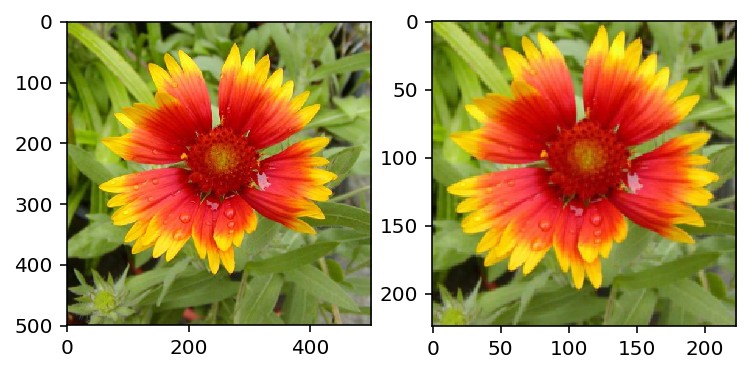

In [25]:
model = models.vgg16(pretrained=True)

image_pil = Image.open('test_flower.jpg')




imshow_simple(image_pil)
    

    
predict('test_flower.jpg',model,5)

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [88]:
# TODO: Display an image along with the top 5 classes
